In [48]:
import torch
import torchaudio
import torchtext
import torchaudio.functional as F
import torchaudio.transforms as T
from audio_augmentations import *

import os, re, random
import numpy as np
import sklearn
import itertools
import time

import pickle
from tqdm.auto import tqdm
from IPython.display import clear_output
import IPython.display as ipd
import gc
import matplotlib.pyplot as plt
import wandb

print(torch.__version__)
print(torchaudio.__version__)

import sys
sys.path.append('..')

2.0.0
2.0.1


In [49]:
random.seed(123456)
np.random.seed(123456)
torch.manual_seed(123456)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [50]:
def plot_waveform(waveform, mfcc, sample_rate=16000, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_frames = waveform.size
    time_axis = torch.arange(0, num_frames) / sample_rate

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    ax1.plot(time_axis, waveform, linewidth=1)
    ax1.set_xlabel('Time')
    ax1.set_title('Signal')

    ax2.specgram(waveform, Fs=sample_rate)
    ax2.set_xlabel('Time')
    ax2.set_title('Spectrogram')

    ax3.imshow(mfcc, interpolation='nearest', origin='lower', aspect='auto')
    ax3.set_xlabel('Frame')
    ax3.set_title('MFCC')

    plt.suptitle(title)
    plt.show()
    
    ax1.grid(True)
    if xlim:
        ax1.set_xlim(xlim)
        
    fig.suptitle(title)
    plt.show()

# Getting data

In [51]:
data_path = '../data'
data_list = []
with open(os.path.join(data_path, 'data_base_audio.pickle'), 'rb') as fh:
  data_list = pickle.load(fh)

data_list

[{'name': 'user_353665394/Сменить_3_1.wav', 'label': 'Сменить'},
 {'name': 'user_353665394/Сменить_3_1_new_1.wav', 'label': 'Сменить'},
 {'name': 'user_353665394/Сменить_3_1_new_2.wav', 'label': 'Сменить'},
 {'name': 'user_353665394/Сменить_3_1_new_3.wav', 'label': 'Сменить'},
 {'name': 'user_353665394/Сменить_3_1_new_4.wav', 'label': 'Сменить'},
 {'name': 'user_353665394/Сменить_3_1_new_5.wav', 'label': 'Сменить'},
 {'name': 'user_353665394/Сменить_3_1_new_6.wav', 'label': 'Сменить'},
 {'name': 'user_439019486/Вверх_5_1.wav', 'label': 'Вверх'},
 {'name': 'user_927009173/Вниз_13_3.wav', 'label': 'Вниз'},
 {'name': 'user_398682235/Сохранить_8_2.wav', 'label': 'Сохранить'},
 {'name': 'user_398682235/Сохранить_8_2_new_1.wav', 'label': 'Сохранить'},
 {'name': 'user_398682235/Сохранить_8_2_new_2.wav', 'label': 'Сохранить'},
 {'name': 'user_398682235/Сохранить_8_2_new_3.wav', 'label': 'Сохранить'},
 {'name': 'user_398682235/Сохранить_8_2_new_4.wav', 'label': 'Сохранить'},
 {'name': 'user_398

In [52]:
all_labels = set()
for example in data_list:
    all_labels.add(example['label'])

all_labels

{'Вверх',
 'Влево',
 'Вниз',
 'Вправо',
 'Двигаться',
 'Домой',
 'Загрузить',
 'Закрыть',
 'Захватить',
 'Найти',
 'Опустить',
 'Остановиться',
 'Открыть',
 'Поднять',
 'Сменить',
 'Сохранить',
 'Старт',
 'Стоп'}

In [53]:
token_to_idx = {x: idx for idx, x in enumerate(all_labels)}

token_to_idx

{'Влево': 0,
 'Домой': 1,
 'Старт': 2,
 'Вниз': 3,
 'Поднять': 4,
 'Опустить': 5,
 'Вправо': 6,
 'Сменить': 7,
 'Открыть': 8,
 'Стоп': 9,
 'Захватить': 10,
 'Закрыть': 11,
 'Остановиться': 12,
 'Загрузить': 13,
 'Вверх': 14,
 'Сохранить': 15,
 'Найти': 16,
 'Двигаться': 17}

split 80:10:10

In [54]:
lengths_subsets = {'train': int(0.8 * len(data_list)), 'valid': round(0.1 * len(data_list)), 'test': round(0.1 * len(data_list))}
train_vaild_subset, test_subset = torch.utils.data.random_split(data_list, 
                                                                [lengths_subsets['train']+lengths_subsets['valid'], lengths_subsets['test']])
train_subset, valid_subset = torch.utils.data.random_split(train_vaild_subset, 
                                                                [lengths_subsets['train'], lengths_subsets['valid']])
lengths_subsets

{'train': 8852, 'valid': 1107, 'test': 1107}

# Creating dataset

In [55]:
class Sound_dataset_commands(torch.utils.data.Dataset):
    def __init__(self, rootdir, subset, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.subset = subset
        self.n_subset = len(self.subset)
        self.token_to_idx = {x: idx for idx, x in enumerate(all_labels)}
        self.idx_to_token = {idx: x for idx, x in enumerate(all_labels)}

    def __getitem__(self, index):
        name, label = self.subset[index].values()
        signal, sample_rate = torchaudio.load(os.path.join(self.rootdir, name))
        signal = signal[0]

        if self.transform:
            feature_map = self.transform(signal)
            signal = self.transform.transforms[0](signal)
        idx_label = self.token_to_idx[label]

        return feature_map, idx_label, signal, name, label

    def __len__(self):
        return len(self.subset)

In [56]:
# 30мс 10мс шаг
n_fft = 480
win_length = None
hop_length = 160
n_mels = 256
n_mfcc = 256
mfcc_transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)
# mfcc_transform = torchaudio.transforms.MFCC(sample_rate=16000)
# temp = mfcc_transform(X)
transforms = [
    RandomApply([Noise(min_snr=0.1, max_snr=0.3)], p=0.5),
    mfcc_transform
]
transform = Compose(transforms=transforms)
data_set = {
            'train': Sound_dataset_commands(rootdir=data_path, subset=train_subset, transform=transform),
            'valid': Sound_dataset_commands(rootdir=data_path, subset=valid_subset, transform=transform),
            'test': Sound_dataset_commands(rootdir=data_path, subset=test_subset, transform=transform)
           }
c = itertools.cycle(data_set['train'])

/Users/litvan007/NN_commands_recognition/.venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (241) may be set too low.
  warnings.warn(


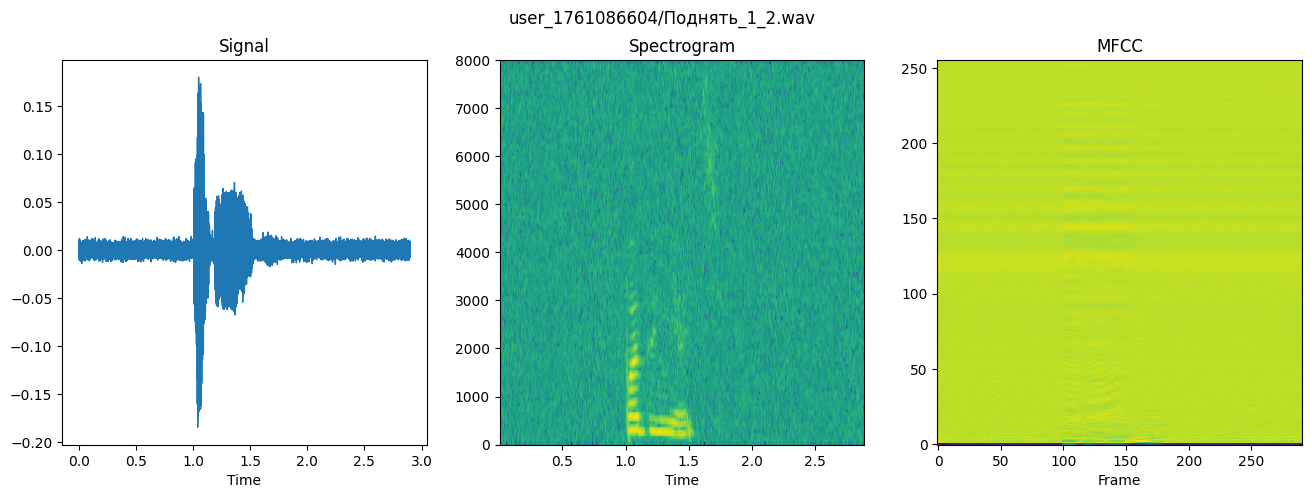

In [57]:
mfcc, label, signal, xname, label = next(c)
plot_waveform(signal, mfcc, sample_rate=16000, title=f'{xname}')
ipd.Audio(signal, rate=16000)

## Wandb data input

In [58]:
def create_plots(signal, feature_map, name_fig, sample_rate=16000, 
                            signal_plot_dir='signal_plots', 
                            spec_plot_dir='spec_plots', 
                            mfcc_plot_dir='mfcc_plots'):
    signal = signal.numpy()

    num_frames = signal.size
    time_axis = torch.arange(0, num_frames) / sample_rate

    plt.plot(time_axis, signal, linewidth=1)
    plt.xlabel('Time')
    plt.title('Signal')
    plt.grid()
    plt.savefig(os.path.join(signal_plot_dir, name_fig))
    plt.clf()

    plt.specgram(signal, Fs=sample_rate)
    plt.xlabel('Time')
    plt.title('Spectrogram')
    plt.savefig(os.path.join(spec_plot_dir, name_fig))
    plt.clf()

    plt.imshow(feature_map, interpolation='nearest', origin='lower', aspect='auto')
    plt.xlabel('Frame')
    plt.title('MFCC')
    plt.savefig(os.path.join(mfcc_plot_dir, name_fig))
    plt.clf()
    

In [59]:
# columns = ["name", "song_file", "signal_plot", "spec_plot", "mfcc_plot", "Label", "Set"]
# table = wandb.Table(columns=columns)

# signal_plot_dir='signal_plots'
# spec_plot_dir='spec_plots'
# mfcc_plot_dir='mfcc_plots'

# # for set_name, curr_data_set in data_set.items():
# #     print(set_name)
# for feature_map, idx_label, signal, name, label in tqdm(data_set['valid']):
#     name_fig = f'{name.replace("/", "_").split(".")[0]}.png'
#     create_plots(signal, feature_map, name_fig)    
#     temp = [name, 
#             wandb.Audio(signal, sample_rate=16000), 
#             wandb.Image(os.path.join( signal_plot_dir, name_fig )),
#             wandb.Image(os.path.join( spec_plot_dir, name_fig )),
#             wandb.Image(os.path.join( mfcc_plot_dir, name_fig )),
#             label, 'valid']
#     table.add_row(*temp)
#     # os.remove(os.path.join( signal_plot_dir, name_fig ))
#     # os.remove(os.path.join( spec_plot_dir, name_fig ))
#     # os.remove(os.path.join( mfcc_plot_dir, name_fig ))

# wandb.run.log({"songs" : table}) 

In [60]:
from models.model import Speech_recognition_model
import yaml

# Сделать разные конфиги
params = None
with open("../configs/model_params.yaml", "r") as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

## Data Loader

In [61]:
def collate_fn(batch):
    # lengths = torch.tensor([len(sample[0]) for sample in batch])
    # max_len = torch.max(lengths)

    X = torch.nn.utils.rnn.pad_sequence([sample[0].transpose(0, 1) for sample in batch], batch_first=True, padding_value=0).unsqueeze(1)
    y = torch.tensor([sample[1] for sample in batch])

    signal = [sample[2] for sample in batch]
    name = [sample[3] for sample in batch]
    label = [sample[4] for sample in batch]

    return X, y, signal, name, label

batch_size = params['architecture']['Others_params']['batch_size']
loaders = {
            'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
            'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
            'test': torch.utils.data.DataLoader(data_set['test'], batch_size=1, shuffle=False, collate_fn=collate_fn)
          }

# Обучение и тестирование
1) Написать оптимизатор и планировщик
2) Прописать функции для обучения с логированием в wandb
3) Показывать примеры валидации во время обучения
4) Прописать перенести pipeline обучения в скрипты (для красоты)
5) Перенести модели в этот ноутбук
6) Запустить обучение на Kaggle

## Wandb init

In [62]:
!wandb login --relogin a4fc0db907801a21173615cb84708e1774b986a4

wandb.init(project="Commands Recognition", name="training_1", config=params)
columns = ["name", "song_file", "signal_plot", "spec_plot", "mfcc_plot", "pred_label", "true_label"]
valid_table = wandb.Table(columns=columns)

wandb: Appending key for api.wandb.ai to your netrc file: /Users/litvan007/.netrc


In [63]:
max_lr = params['architecture']['Optimizer_Scheduler']['max_lr']
div_factor = params['architecture']['Optimizer_Scheduler']['div_factor']
weight_decay = params['architecture']['Optimizer_Scheduler']['weight_decay']
amsgrad = params['architecture']['Optimizer_Scheduler']['amsgrad']
epochs = params['architecture']['Others_params']['epochs']
max_norm = params['architecture']['Optimizer_Scheduler']['max_norm']

params['architecture'].pop('Optimizer_Scheduler')

model = Speech_recognition_model(**(params['architecture']))
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),
                              lr=max_lr/div_factor,
                              weight_decay=weight_decay,
                              amsgrad=amsgrad)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                            steps_per_epoch=len(loaders['train']),
                            epochs=epochs, div_factor=div_factor)
model

Speech_recognition_model(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((1

In [82]:
temp = torch.tensor([[0, 1, 0], [1, 0, 0], [0, 0, 1]])
temp.argmax(1)

tensor([1, 0, 2])

In [83]:
def get_accuracy(y_pred, y_test):
    print(y_pred.size(), y_test.size())
    correct_results_sum = (y_pred == y_test).sum().float()
    acc = correct_results_sum/(y_test.size(0))
    
    return acc

In [84]:
signal_plot_dir='signal_plots'
spec_plot_dir='spec_plots'
mfcc_plot_dir='mfcc_plots'

def run_one_epoch(epoch, cross_valid=False, print_freq=1):
    start = time.time()
    total_loss = 0
    accuracy = 0

    data_loader = loaders['train'] if not cross_valid else loaders['valid']

    for i, (data) in enumerate(tqdm(data_loader)):
        feature_map, idx_label, signal, name, label = data
        input_data = feature_map.to(device)
        target_labels = idx_label.to(device)

        output_logits = model(input_data)
        loss = criterion(output_logits, target_labels)
        if not cross_valid:
            optimizer.zero_grad()
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                        max_norm)
            optimizer.step()

        total_loss += loss.item()
        pred_labels = torch.round(torch.sigmoid(output_logits)).type(torch.int8).argmax(1)
        accuracy += get_accuracy(pred_labels, target_labels)
        if i % print_freq == 0:
                print('Epoch {0} | Iter {1} | Average Loss {2:.3f} | '
                      'Current Loss {3:.6f} | Current accuracy {4:.6f} | {5:.1f} ms/batch'.format(
                          epoch + 1, i + 1, total_loss / (i + 1),
                          loss.item(), accuracy, 1000 * (time.time() - start) / (i + 1)),
                      flush=True)

        if cross_valid:
            name_fig = f'{name[0].replace("/", "_").split(".")[0]}.png'
            create_plots(signal, feature_map, name_fig)    
            temp = [name[0], 
                wandb.Audio(signal[0], sample_rate=16000), 
                wandb.Image(os.path.join( signal_plot_dir, name_fig )),
                wandb.Image(os.path.join( spec_plot_dir, name_fig )),
                wandb.Image(os.path.join( mfcc_plot_dir, name_fig )),
                pred_labels[0],
                target_labels[0]]
            valid_table.add_row(*temp)
        
    return total_loss / (i + 1), accuracy / (i + 1)

In [85]:
torch.cuda.empty_cache()
gc.collect()

epoch = 0
checkpoint = False
visdom = True
save_folder = './checkpoints'

tr_loss = []
cv_loss = []
tr_acc = []
cv_acc = []
best_val_loss = 100

wandb.watch(model)
for epoch in tqdm(np.arange(epoch, epochs)):
    print("Training...")
    model.train()
    start = time.time()
    tr_avg_loss, tr_avg_acc = run_one_epoch(epoch)
    tr_loss.append(tr_avg_loss)
    tr_acc.append(tr_avg_acc)

    print('-' * 85)
    print('Train Summary | End of Epoch {0} | Time {1:.2f}s | '
                  'Train Loss {2:.3f} | Accuracy {3:.3f}'.format(
                      epoch + 1, time.time() - start, tr_avg_loss, cv_avg_acc))
    print('-' * 85)

    if checkpoint:
                file_path = os.path.join(
                save_folder, 'epoch%d.pth.tar' % (epoch + 1))
                torch.save(model.serialize(model, optimizer, scheduler, epoch + 1,
                                                tr_loss=tr_loss,
                                                cv_loss=cv_loss),
                           file_path)
                print('Saving checkpoint model to %s' % file_path)

    print('Cross validation...')
    model.eval()  # Turn off Batchnorm & Dropout
    cv_avg_loss, cv_avg_acc = run_one_epoch(epoch, cross_valid=True)
    cv_loss.append(cv_avg_loss)
    cv_loss.append(cv_avg_acc)

    print('-' * 85)
    print('Valid Summary | End of Epoch {0} | Time {1:.2f}s | '
            'Valid Loss {2:.3f} | Accuracy {3:.3f}'.format(
                epoch + 1, time.time() - start, cv_avg_loss, cv_avg_acc))
    print('-' * 85)

    # Save the best model
    if cv_avg_loss < best_val_loss:
        best_val_loss = cv_avg_loss
        model_path = 'epoch%d_best.pth.tar' % (epoch + 1)
        file_path = os.path.join(save_folder, model_path)
        torch.save(model.serialize(model, optimizer, scheduler, epoch + 1,
                                        tr_loss=tr_loss,
                                        cv_loss=cv_loss),
                    file_path)
        print("Find better validated model, saving to %s" % file_path)
    
    optim_state = optimizer.state_dict()
    curr_lr = optim_state['param_groups'][0]['lr']

    wandb.log({"train_loss": tr_avg_loss})
    wandb.log({"valid_loss": cv_avg_loss})
    wandb.log({"train_accuracy": tr_avg_acc})
    wandb.log({"valid_accuracy": cv_avg_loss})
    wandb.log({"Learning rate": curr_lr})
    wandb.run.log({"valid_inference" : valid_table}) 

wandb.finish()
    

  0%|          | 0/10 [00:00<?, ?it/s]

Training...


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 1 | Average Loss 2.901 | Current Loss 2.901108 | 536681.9 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 2 | Average Loss 2.888 | Current Loss 2.874244 | 517595.7 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 3 | Average Loss 2.917 | Current Loss 2.975719 | 513934.7 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 4 | Average Loss 2.954 | Current Loss 3.065207 | 520397.3 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 5 | Average Loss 2.942 | Current Loss 2.891594 | 529155.5 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 6 | Average Loss 2.932 | Current Loss 2.885188 | 524915.3 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 7 | Average Loss 2.923 | Current Loss 2.868011 | 523245.0 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 8 | Average Loss 2.923 | Current Loss 2.922415 | 519600.5 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 9 | Average Loss 2.925 | Current Loss 2.938426 | 518816.4 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 10 | Average Loss 2.926 | Current Loss 2.936356 | 518602.1 ms/batch


torch.Size([128]) torch.Size([128])
Epoch 1 | Iter 11 | Average Loss 2.922 | Current Loss 2.879152 | 526752.2 ms/batch


## Мысли насчет Wandb Sweep